<a href="https://colab.research.google.com/github/SteveWong-a/COSMOS-ratplacecelldata/blob/main/LSTM_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In your Jupyter Notebook cell
import scipy.io
import numpy as np

# --- Load the .mat file ---
# IMPORTANT: Replace this with the actual path to your file
file_path = "/Users/stevew/Projects/COSMOS/data/COSMO_data_openfield_IMG10_0713.mat"

try:
    mat_data = scipy.io.loadmat(file_path)
    cosmos_data = mat_data['COSMO_data']
    print("✅ Successfully loaded the .mat file!")

    # Extract field names
    field_names = cosmos_data.dtype.names
    print(f"Fields found in COSMO_data: {field_names}")

except FileNotFoundError:
    print(f"❌ Error: The file was not found at '{file_path}'")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully loaded the .mat file!
Fields found in COSMO_data: ('timestamps', 'calcium_signal', 'coordinates', 'head_orientation', 'segment_time')


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- 1. Load and Prepare Base Arrays ---
# Extract data from the loaded MATLAB struct
calcium_signal = cosmos_data[0, 0]['calcium_signal']
head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])

# --- 2. Cleanse Data: Remove low-variance neurons ---
variance = np.var(calcium_signal, axis=0)
low_variance_threshold = 1e-7
low_variance_indices = np.where(variance < low_variance_threshold)[0]
if len(low_variance_indices) > 0:
    print(f"⚠️ Found and removing {len(low_variance_indices)} low-variance neurons.")
    calcium_signal = np.delete(calcium_signal, low_variance_indices, axis=1)
print(f"Shape of calcium signal after cleaning: {calcium_signal.shape}")

# --- 3. Create Sequences for the RNN ---
# This function will reshape our data into sequences
def create_sequences(X_data, y_data, sequence_length):
    X_sequences, y_sequences = [], []
    for i in range(len(X_data) - sequence_length):
        # The sequence of features
        X_sequences.append(X_data[i:i + sequence_length])
        # The target is the value at the end of the sequence
        y_sequences.append(y_data[i + sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Define the length of the look-back window
SEQUENCE_LENGTH = 15 # The model will look at the past 15 time steps

# Create the sequences
# The target `y` will be the (cos, sin) of the angle
y_circular = np.stack([np.cos(head_orientation), np.sin(head_orientation)], axis=1)
X_seq, y_seq = create_sequences(calcium_signal, y_circular, SEQUENCE_LENGTH)

print(f"\nShape of X sequences: {X_seq.shape}") # (n_samples, sequence_length, n_features)
print(f"Shape of y sequences: {y_seq.shape}")   # (n_samples, 2)


# --- 4. Split and Scale Data ---
# Note: We scale the features *after* creating sequences
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Scale the input features (X)
# We reshape to 2D for the scaler, then reshape back to 3D
num_samples, seq_len, num_features = X_train.shape
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, num_features)).reshape(num_samples, seq_len, num_features)

num_samples_test = X_test.shape[0]
X_test_scaled = x_scaler.transform(X_test.reshape(-1, num_features)).reshape(num_samples_test, seq_len, num_features)

# Impute any potential NaNs
if np.isnan(X_train_scaled).any():
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
if np.isnan(X_test_scaled).any():
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

# --- 5. Prepare Data for PyTorch ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("\n✅ Data is now ready for the RNN model.")

Shape of calcium signal after cleaning: (14278, 168)

Shape of X sequences: (14263, 15, 168)
Shape of y sequences: (14263, 2)


/Users/stevew/Projects/COSMOS/cosmos/env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/Projects/COSMOS/cosmos/env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/Projects/COSMOS/cosmos/env/lib/python3.11/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



✅ Data is now ready for the RNN model.


In [ ]:
# --- Define the LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.output_fc = nn.Linear(64, 2) # Output for cos and sin
        self.tanh = nn.Tanh()

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # We only need the output from the last time step
        last_time_step_out = lstm_out[:, -1, :]

        # Fully connected layers
        x = self.fc(last_time_step_out)
        x = self.relu(x)
        x = self.output_fc(x)
        x = self.tanh(x)
        return x

# --- Initialize ---
input_size = X_train_scaled.shape[2] # Number of neurons
hidden_size = 128 # Number of features in the LSTM hidden state
num_layers = 2    # Number of stacked LSTM layers

model = LSTMModel(input_size, hidden_size, num_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# --- Training Loop ---
epochs = 50 # RNNs can take longer to train
print("\n🚀 Starting LSTM model training...")
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
print("✅ Training complete.")


🚀 Starting LSTM model training...
Epoch [5/50], Loss: 0.0258
Epoch [10/50], Loss: 0.0174
Epoch [15/50], Loss: 0.0100
Epoch [20/50], Loss: 0.0090
Epoch [25/50], Loss: 0.0036
Epoch [30/50], Loss: 0.0039
Epoch [35/50], Loss: 0.0056
Epoch [40/50], Loss: 0.0072
Epoch [45/50], Loss: 0.0061
Epoch [50/50], Loss: 0.0049
✅ Training complete.


In [ ]:
SAVE_PATH = "/Users/stevew/Projects/COSMOS/data/lstm_model.pth"
torch.save(model.state_dict(), SAVE_PATH)


LSTM Model Performance on Test Data:
Mean Absolute Angular Error: 0.081 radians (~4.6 degrees)


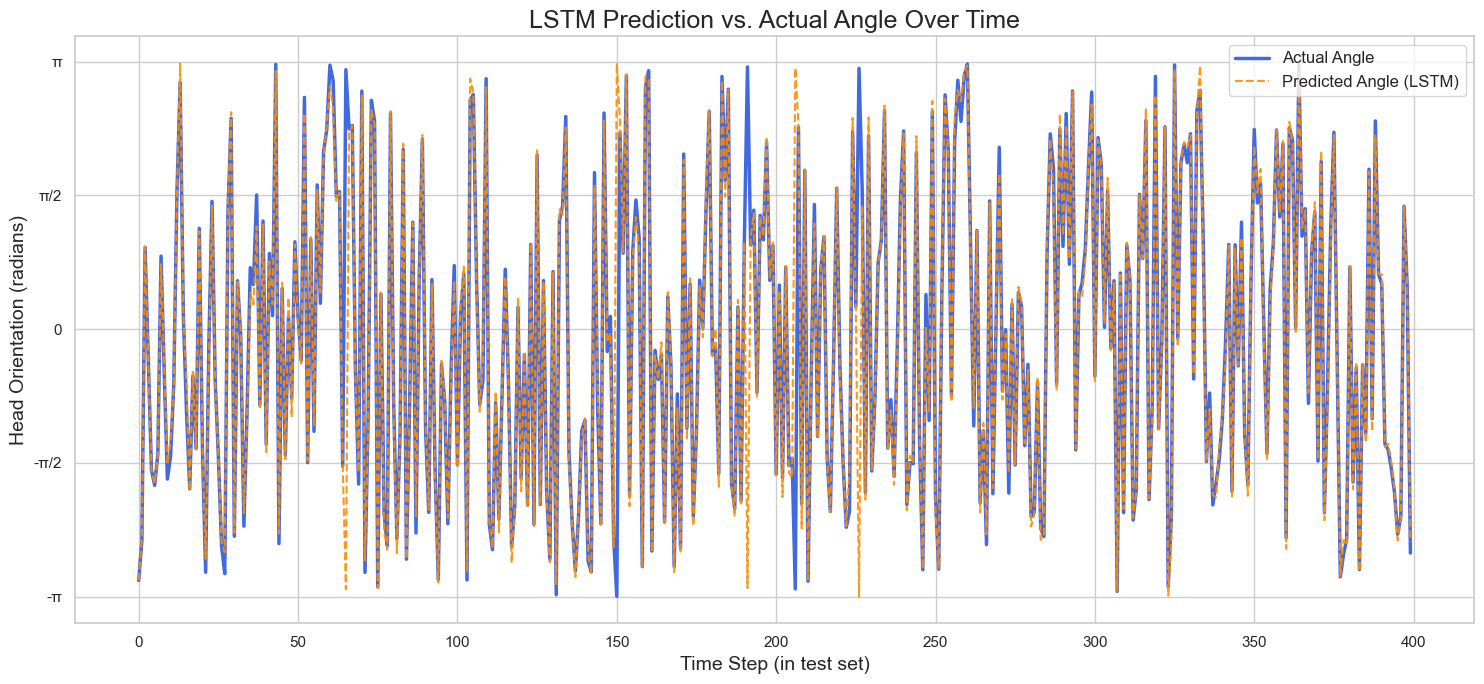

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluation ---
model.eval()
with torch.no_grad():
    predictions_xy = model(X_test_tensor)
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0])
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0])

    diff = true_angles - predicted_angles
    angular_error = torch.atan2(torch.sin(diff), torch.cos(diff))
    mean_error_rad = torch.mean(torch.abs(angular_error))
    mean_error_deg = torch.rad2deg(mean_error_rad)
    print(f"\nLSTM Model Performance on Test Data:")
    print(f"Mean Absolute Angular Error: {mean_error_rad:.3f} radians (~{mean_error_deg:.1f} degrees)")

# --- Visualization Over Time ---
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
time_slice = slice(0, 400)
time_axis = np.arange(400)

plt.plot(time_axis, true_angles.numpy()[time_slice], label='Actual Angle', linewidth=2.5, color='royalblue')
plt.plot(time_axis, predicted_angles.numpy()[time_slice], label='Predicted Angle (LSTM)', linestyle='--', alpha=0.9, color='darkorange')

plt.title('LSTM Prediction vs. Actual Angle Over Time', fontsize=18)
plt.xlabel('Time Step (in test set)', fontsize=14)
plt.ylabel('Head Orientation (radians)', fontsize=14)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

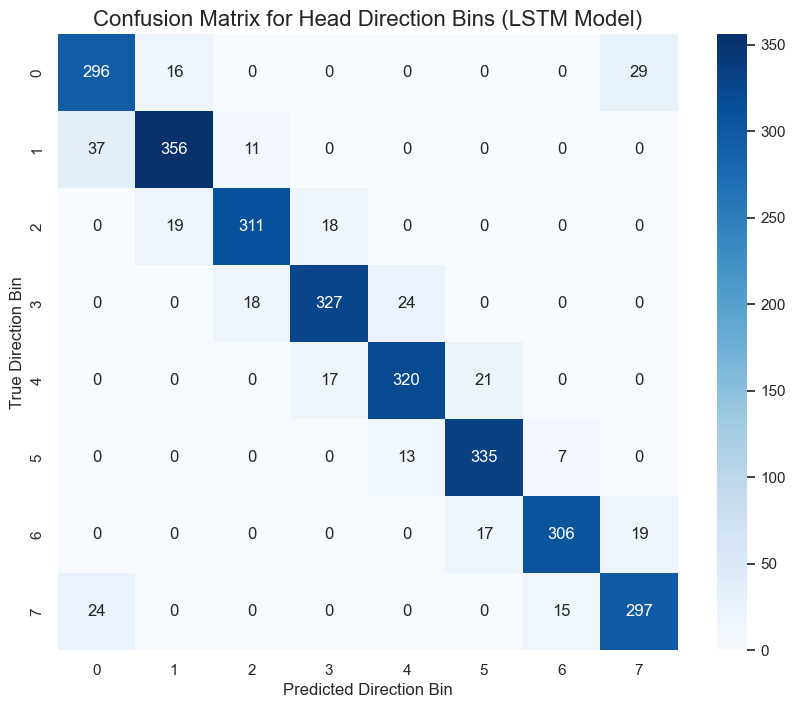

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This cell assumes the 'model' (your LSTM) and the test tensors
# ('X_test_tensor', 'y_test_tensor') are available from the previous step.

# --- 1. Generate Continuous Angle Predictions ---
model.eval()
with torch.no_grad():
    # Get the (cos, sin) predictions from the model
    predictions_xy = model(X_test_tensor)

    # Convert both predicted and true (cos, sin) pairs back to angles
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0]).numpy()
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0]).numpy()

# --- 2. Bin Both True and Predicted Angles into 8 Categories ---
# This is the key fix: we put both sets of angles into the same bins.
bins = np.linspace(-np.pi, np.pi, 9) # 9 edges for 8 bins
labels = np.arange(8)                # Labels will be 0, 1, ..., 7

# Bin the true angles
true_bins = pd.cut(true_angles, bins=bins, labels=labels, include_lowest=True)
true_bins = true_bins.to_numpy().astype(int)

# Bin the predicted angles
predicted_bins = pd.cut(predicted_angles, bins=bins, labels=labels, include_lowest=True)
predicted_bins = predicted_bins.to_numpy().astype(int)


# --- 3. Create and Plot the Confusion Matrix ---
# Now, both inputs are integer class labels, so this will work.
cm = confusion_matrix(true_bins, predicted_bins)

plt.figure(figsize=(10, 8))
sns.set_theme(style="white")
sns.heatmap(cm,
            annot=True,          # Show the numbers in each cell
            fmt='d',             # Format numbers as integers
            cmap='Blues',        # Use a blue color scheme
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix for Head Direction Bins (LSTM Model)', fontsize=16)
plt.xlabel('Predicted Direction Bin', fontsize=12)
plt.ylabel('True Direction Bin', fontsize=12)
plt.show()

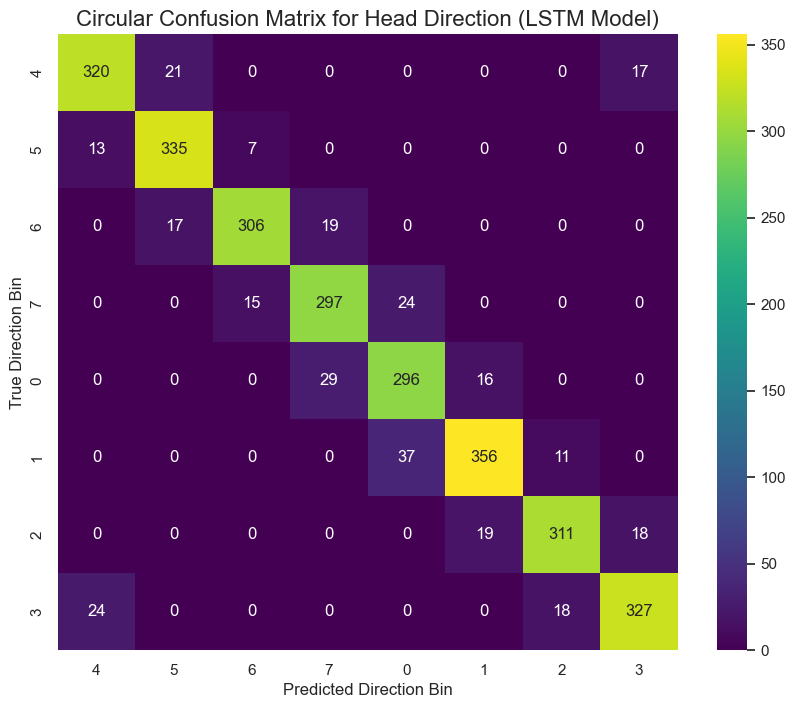

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# This cell assumes the 'model' (your trained LSTM) and the test tensors
# ('X_test_tensor', 'y_test_tensor') are available from the previous step.

# --- 1. Generate Continuous Angle Predictions from the LSTM ---
model.eval()
with torch.no_grad():
    # Get the (cos, sin) predictions from the model
    predictions_xy = model(X_test_tensor)

    # Convert both predicted and true (cos, sin) pairs back to angles
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0]).numpy()
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0]).numpy()

# --- 2. Bin Both True and Predicted Angles into 8 Categories ---
# This is the key step to prepare the data for the confusion matrix
bins = np.linspace(-np.pi, np.pi, 9) # 9 edges for 8 bins
labels = np.arange(8)                # Labels will be 0, 1, ..., 7

# Bin the true angles
true_bins = pd.cut(true_angles, bins=bins, labels=labels, include_lowest=True, right=True)
true_bins = true_bins.to_numpy().astype(int)

# Bin the predicted angles
predicted_bins = pd.cut(predicted_angles, bins=bins, labels=labels, include_lowest=True, right=True)
predicted_bins = predicted_bins.to_numpy().astype(int)


# --- 3. Create and Plot the Circular Confusion Matrix ---
# Now, both inputs are integer class labels, so this will work correctly.
cm = confusion_matrix(true_bins, predicted_bins)

# Reorder the indices to create the circular effect
reordered_indices = [4, 5, 6, 7, 0, 1, 2, 3]
reordered_cm = cm[reordered_indices, :][:, reordered_indices]
reordered_labels = [str(i) for i in reordered_indices]

plt.figure(figsize=(10, 8))
sns.set_theme(style="white")
sns.heatmap(reordered_cm,
            annot=True,
            fmt='d',
            cmap='viridis',
            xticklabels=reordered_labels,
            yticklabels=reordered_labels)

plt.title('Circular Confusion Matrix for Head Direction (LSTM Model)', fontsize=16)
plt.xlabel('Predicted Direction Bin', fontsize=12)
plt.ylabel('True Direction Bin', fontsize=12)
plt.show()